<a href="https://colab.research.google.com/github/ua-datalab/MLWorkshops/blob/main/Autoencoders/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

This tutorial uses a GPU for training the autoencoder examples. This [tutorial](https://www.geeksforgeeks.org/how-to-use-gpu-in-google-colab/) will show you how to connect to a runtime with a GPU.

Overview of the contents of the notebook:
1. Autoencoder example using MNIST and fully connected layers, trained using mean squared error between the original image and the reconstruction.
2. As above, but utilizing convolutional layers, which requires deconvolutional layers in the decoder to upsample to the original image size.

In [ ]:
%pip install lightning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import os

import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image

import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelSummary

from skimage.util import random_noise

Throughout this notebook we will be using the MNIST dataset, which is provided to us from [torchvision.datasets](https://pytorch.org/vision/main/datasets.html). The images are downloaded in PIL (Python Imaging Library) format.

## Autoencoder 1 : Fully connected neural network

### Load the dataset
[torchvision.transforms](https://pytorch.org/vision/main/transforms.html) is a module that provides common computer vision transforms to support training vision models. These are used to prepare data for training and testing by transforming it into a format that works with the neural network.

Using [torchvision.transforms.Compose](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html), we can create a list of transformations to apply to every image in the dataset. In this example, we first turn our PIL images into Tensors, which is the input to our neural network. Next, we normalize each image with a mean and standard deviation of 0.5. Finally, we flatten the image from a WxH Tensor into a W*H Tensor (analogous to flattening from a matrix into a vector).

Because there is not a tranform that flattens tensors, we use a lambda function to achieve this. Using this, we can give Compose any function we want, and it will apply it to the output of the previous step.

As in any machine learning context, we split the data into training, validation, and test sets. Then, we wrap these datasets in a [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allows us to easily iterate through our data. Each iteration will return BATCH_SIZE x DATA_SIZE samples.

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                                transforms.Lambda(lambda x: torch.flatten(x))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=os.getcwd(), train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [55000, 5000])

# Loading the test set
test_set = MNIST(root=os.getcwd(), train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 80882663.77it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 99618169.26it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31842440.05it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16948869.01it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



### Architecture

The following block of code contains the architecture of the autoencoder. Note that the class has been written so that we can customize the input size and latent dimension size when initializing a new instance of the Autoencoder class. This code uses the default values.

For the MNIST images, the input size is 28*28=784. The Encoder uses four fully connected layers ([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) to slowly reduce the size of the input to that of the latent dimension. ReLU is used as the activation function throughout.

The Decoder uses the same architecture as the encoder in reverse, stepping from the size of the latent dimension back up to the input size.

The training, validation, and test steps all reside in the Autoencoder class. We use mean squared error as the reconstruction loss, and use an ADAM optimizer to train the network.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layers(x)

class Decoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_size),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layers(x)

class Autoencoder(L.LightningModule):
    def __init__(self, input_size=784, latent_dim=64):
        super().__init__()

        self.encoder = Encoder(input_size, latent_dim)
        self.decoder = Decoder(input_size, latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _loss(self, batch):
        x, _ = batch
        x_hat = self.forward(x)
        return F.mse_loss(x, x_hat, reduction='mean')

    def training_step(self, batch, batch_idx):
        loss = self._loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._loss(batch)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return {'optimizer': optimizer, 'monitor': 'val_loss'}

### Training
With the architecture defined, we can now train the model. Notice that the Autoencoder class inherits from L.LightningModule. Lightning is a wrapper for Pytorch code that allows us to work at a slightly higher level. Rather than writing a training loop and performing the gradient step, we can simply create a [Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html) and it will perform the training loop for us. In this case, we provide arguments letting the trainer know that we can run training on a single GPU.

Callbacks will trigger if some condition is met. In this case, we set an EarlyStopping callback to end training early if validation loss does not improve after three epochs. This is a useful tool to prevent overfitting the training data and save computation time.

In [ ]:
autoencoder = Autoencoder()

trainer = L.Trainer(accelerator='gpu',
                    devices=1,
                    callbacks=EarlyStopping(monitor='val_loss', mode='min', patience=3))

trainer.fit(autoencoder, train_loader, val_loader)

Because we set up logging using the self.log calls inside of Autoencoder, we can view various information about the run using tensorboard (the default logger for LightningModules).

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

### Visualization
With the model trained, let's take a look at some outputs. The compare_imgs function will show two images, side by side, as well as calculate and display the MSE between them.

In [ ]:
def compare_imgs(img1, img2):
    loss = F.mse_loss(img1, img2, reduction='sum')

    # Reshape from one dimensional tensor to a square image
    img1 = torch.reshape(img1, (1,28,28))
    img2 = torch.reshape(img2, (1,28,28))

    # Utilize torchvision utils to add images to a grid that we can plot with plt
    grid = torchvision.utils.make_grid([img1, img2], nrow=2, normalize=True, value_range=(0,1))
    grid = grid.permute(1, 2, 0)

    plt.figure(figsize=(4, 2))
    plt.title(f"Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

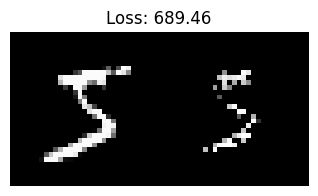

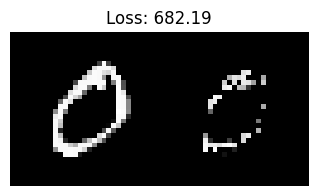

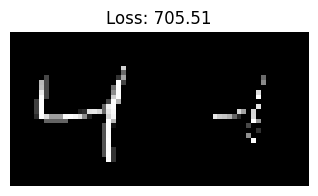

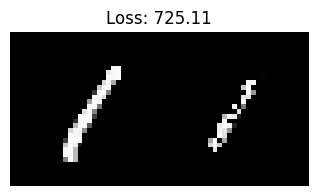

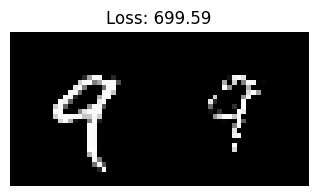

In [ ]:
for i in range(5):
    img = train_dataset[i][0]
    reconstruction = autoencoder(img)
    compare_imgs(img, reconstruction)


Looks patchy! This should not be too surprising, given that we know that fully connected neural networks are not the best choice for dealing with image data. This problem could be alleviated by providing the neural network with more representational power, either by increasing the latent dimension, or by adding more layers to the encoder and decoder. (A good exercise if you are interested!)

However, we also know that fully connected neural networks are not the best at learning on image data, which leads to our next example.

## Autoencoder 2: Using convolutional layers

### Loading the dataset

Again, we utilize transforms when loading our data. Notice that we have dropped the flattening step, because the convolutional layers of our network can take the 28x28 images as is.

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=os.getcwd(), train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [55000, 5000])

# Loading the test set
test_set = MNIST(root=os.getcwd(), train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=2)

### Architecture

The fully connected layers in the CNNEncoder have been replaced by [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) layers. The size of the output of the Conv2d layer is a function of the kernel size, padding, stride, and dilation. The output of a MaxPool2d layer is a function of the same variables - in this case, the kernel size and stride are both 2, meaning that the input size is cut in half at each point.

After some math, you can find that the latent dimension size is 16\*3\*3=144.

The decoder uses [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) layers, which learn kernels to perform convolution but also perform an upsampling operation which you can think of as expanding the input size by copying the value of a single pixel in a smaller image to multiple pixels in the larger output image. Similarly, the size of the output is dictated by the setting of the kernel size and other parameters.

The CNNAutoencoder class is the same, except for using the new CNNEncoder and CNNDecoder.


In [ ]:
class CNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.layers(x)

class CNNDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=2, stride=2),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layers(x)

class CNNAutoencoder(L.LightningModule):
    def __init__(self, input_size=784, latent_dim=64):
        super().__init__()

        self.encoder = CNNEncoder()
        self.decoder = CNNDecoder()

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _loss(self, batch):
        x, _ = batch
        x_hat = self.forward(x)
        return F.mse_loss(x, x_hat, reduction='mean')

    def training_step(self, batch, batch_idx):
        loss = self._loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._loss(batch)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return {'optimizer': optimizer, 'monitor': 'val_loss'}

### Training

The only change here is to add a ModelSummary callback, which will print out an overview of our model at the start of training.

In [ ]:
cnn_autoencoder = CNNAutoencoder()

trainer = L.Trainer(accelerator='gpu',
                    devices=1,
                    callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=3),
                               ModelSummary(max_depth=-1)])

trainer.fit(cnn_autoencoder, train_loader, val_loader)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RA

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


### Visualization

We reuse the same compare_imgs function from the previous section. In this case, both the training image and the reconstruction are housed in memory on the GPU, and we need to move these over to the CPU.

The is_cuda attribute is True if the tensor is on the GPU. The detach() method will transfer this tensor over to the CPU memory, where we can pass it to compare_images and plot it without issue.

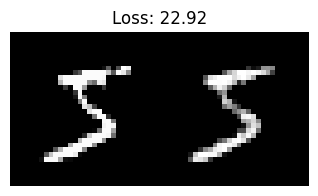

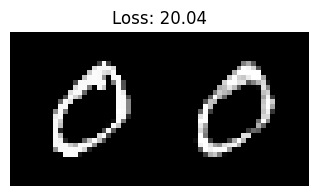

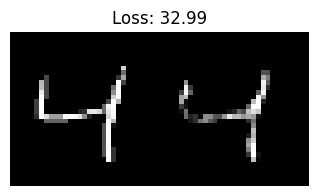

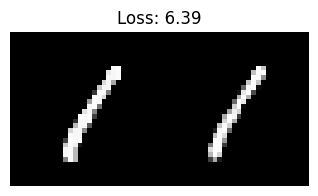

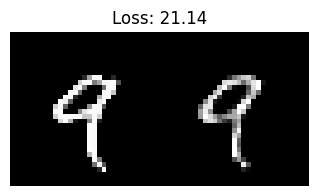

In [ ]:
for i in range(5):
    img = train_dataset[i][0]
    reconstruction = cnn_autoencoder(img)

    if img.is_cuda:
        img = img.detach()
    if reconstruction.is_cuda:
        reconstruction = reconstruction.detach()
    compare_imgs(img, reconstruction)

## Denoising take-home example

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=os.getcwd(), train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [55000, 5000])

# Loading the test set
test_set = MNIST(root=os.getcwd(), train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 77484948.22it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 25599259.05it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25333677.90it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15928535.76it/s]


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [ ]:
def save_noisy_img(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

def gaussian_noise(img):
    return img + np.sqrt(0.1)*torch.randn(img.shape)

def salt_and_pepper(img):
    img = img.numpy()
    noisy_img = random_noise(img, mode='s&p')
    return torch.from_numpy(noisy_img)

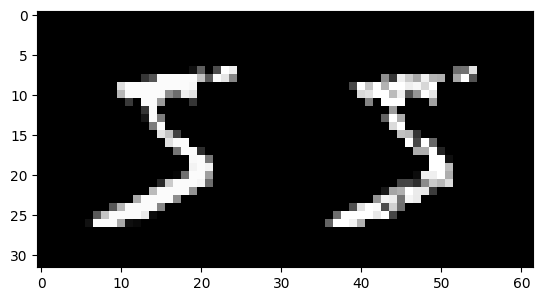

In [ ]:
img, _ = train_dataset[0]
noisy_img = gaussian_noise(img)

grid = make_grid([img, noisy_img], nrow=2, normalize=True, value_range=(0,1))
grid = grid.permute(1, 2, 0)
plt.imshow(grid)

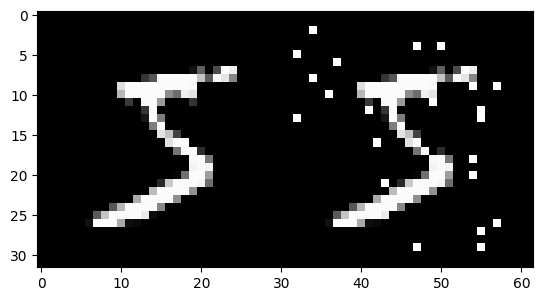

In [ ]:
img, _ = train_dataset[0]
noisy_img = salt_and_pepper(img)

grid = make_grid([img, noisy_img], nrow=2, normalize=True, value_range=(0,1))
grid = grid.permute(1, 2, 0)
plt.imshow(grid)